# Previsão da probabilidade de abstenção do candidato
- Neste notebook, será realizada uma tarefa de classificação, que consiste na previsão da probabilidade de abstenção do candidato no enem (target binário, presente/ausente, 1/0, dados desbalanceados) com base nas variáveis que vimos na análise exploratória de dados. Será aplicado o aprendizado supervisionado, com um conjunto de dados rotulado e um target binário.
- O objetivo consiste em construir um modelo de machine learning capaz de prever, com confiança, a probabilidade de abstenção do candidato. Além disso, avaliar quais variáveis independentes impactam mais e menos a abstenção.
- Para isso, técnicas de limpeza e pré-processamento de dados, treinamento e validação de modelos de machine learning serão aplicadas.
- Todo esse processo será baseado no framework CRISP-DM, podendo envolver ciclos de pré-processamento e validação de modelos repetidamente.
- Pipeline de modelagem:
    - Divisão dos dados em treino, teste e validação.
    - Limpeza e pré-processamento dos dados.
    - Comparação e seleção de modelo potencial com validação cruzada k-fold.
    - Seleção de features.
    - Tunagem de hiperparâmetros.
    - Avaliação final no conjunto de testes (simulando o ambiente de produção).
    - Deploy.
- Finalmente, um modelo de previsão de probabilidade de abstenção pode ser uma ferramenta valiosa para melhorar a eficácia das políticas educacionais e facilitar o processo de organização de exames. Alguns exemplos de aplicações:
    - Identificação de Riscos de Abstenção.
    - Intervenções Preventivas.
    - Aprimoramento da Comunicação.
    - Otimização de Recursos.
    - Planejamento Estratégico.
    - Avaliação do Impacto de Medidas Anteriores.
    - Melhoria da Qualidade do Exame.

#### 1. Importando as bibliotecas

In [1]:
# Data manipulation and visualization.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from feature_engine.selection import ProbeFeatureSelection
import optuna
import shap
shap.initjs()

# Definições de cores -> todas estão numa escala de mais escura para mais clara.
VERMELHO_FORTE = '#461220'
CINZA1, CINZA2, CINZA3 = '#231F20', '#414040', '#555655'
CINZA4, CINZA5, CINZA6 = '#646369', '#76787B', '#828282'
CINZA7, CINZA8, CINZA9 = '#929497', '#A6A6A5', '#BFBEBE'
AZUL1, AZUL2, AZUL3, AZUL4 = '#174A7E', '#4A81BF', '#94B2D7', '#94AFC5'
VERMELHO1, VERMELHO2, VERMELHO3, VERMELHO4, VERMELHO5 = '#DB0527', '#E23652', '#ED8293', '#F4B4BE', '#FBE6E9'
VERDE1, VERDE2 = '#0C8040', '#9ABB59'
LARANJA1 = '#F79747'
AMARELO1, AMARELO2, AMARELO3, AMARELO4, AMARELO5 = '#FFC700', '#FFCC19', '#FFEB51', '#FFE37F', '#FFEEB2'
BRANCO = '#FFFFFF'

# Visualize all the columns.
pd.set_option('display.max_columns', None)

# Filter warnings.
import warnings
warnings.filterwarnings('ignore')

# Utils
from src.modelling_utils import *
from src.eda_utils import bar_plot

/Users/pedrohenriquealmeidaoliveira/Documents/data_science/Enem-Analysis/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 2. Coletando os dados
- Considerando que estamos tentando prever a probabilidade de abstenção do candidato, serão incluídos na modelagem todos os dados, como visto na Análise de Abstenção no notebook '2_eda.ipynb'. Dessa forma, incluiremos não só os estudantes que compareceram, mas também aqueles que faltaram ao exame, os quais serão o alvo da modelagem.
- Antes de tudo, iremos criar o target para a modelagem de abstenção, que consiste em uma variável dummy, indicando se o aluno estava ausente em pelo menos um dos dias de prova (1) ou presente (0, em ambos os dias de prova). Isso permitirá a divisão dos dados em treino, teste e validação e a aplicação correta do pré-processamento dos dados.

In [2]:
# Read the memory optimized data.
path = '/Users/pedrohenriquealmeidaoliveira/Documents/data_science/Enem-Analysis/input/data/clean_df.parquet'
df = pd.read_parquet(path)

# Create our target, a feature indicating wheter the student was absent in at least one day of the exam (1).
df['abstencao'] = (df['presenca_lc'] == 'Ausente') | \
                  (df['presenca_ch'] == 'Ausente') | \
                  (df['presenca_cn'] == 'Ausente') | \
                  (df['presenca_mt'] == 'Ausente') 
df['abstencao'] = df['abstencao'].astype('int8')

- Estamos lidando com uma tarefa de classificação desbalanceada. O nosso target contempla 32.42% de observações positivas para abstenção (evento de interesse).
- Portanto, algumas estratégias de modelagem serão adotadas:
    - Feature engineering na criação de features que ajudem o modelo a discriminar entre o evento (abstenção, 1) e o não evento.
    - Divisão ESTRATIFICADA dos dados em treino, teste e validação.
    - Validação cruzada k-fold ESTRATIFICADA para acessar a capacidade de generalização do modelo e realizar testes de forma confiável.
    - Utilização de hiperparâmetro class_weight, para permitir que o modelo aprenda melhor os padrões na classe rara (abstenção, 1).
    - Escolha de métricas orientadas a uma avaliação de performance condizente com o desbalanceamento, como PR-AUC e ROC-AUC.
- Apesar de os nossos dados estarem desbalanceados, esse desbalanceamento não é alarmante. Considerando que há mais de 3 milhões de observações, é provável que não tenhamos problemas com essa característica e o modelo seja capaz de aprender bem os padrões por trás da classe rara. Entretanto, para fins de metodologia, garantia de performance e conhecimento, serão seguidas as técnicas supracitadas.

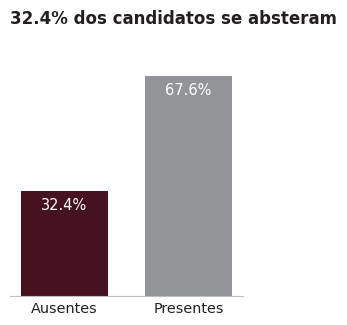

In [3]:
# Group the data by the target.
abstencao_grouped = df.groupby(['abstencao'])[['abstencao']].count().rename(columns={'abstencao': 'count'}).reset_index().sort_values(by=['count'], ascending=False)
abstencao_grouped['pct'] = round(abstencao_grouped['count'] / np.sum(abstencao_grouped['count']) * 100, 2) 
abstencao_grouped = abstencao_grouped.sort_values(by=['pct'], ascending=True)
abstencao_grouped['abstencao'].iloc[0] = 'Ausentes'
abstencao_grouped['abstencao'].iloc[1] = 'Presentes'

bar_plot(abstencao_grouped, 'abstencao', 'pct', title='32.4% dos candidatos se absteram',
         xlabel='', figsize=(3, 3), barwidth=0.7, bar_color=[VERMELHO_FORTE, CINZA7], )

#### 2.1 Rápida visualização e informações gerais

In [3]:
df.head()

,faixa_etaria,sexo,estado_civil,status_conclusao_ensino_medio,escola,treineiro,municipio_prova,uf_prova,presenca_cn,presenca_ch,presenca_lc,presenca_mt,nota_cn,nota_ch,nota_lc,nota_mt,lingua,nota_comp1,nota_comp2,nota_comp3,nota_comp4,nota_comp5,nota_redacao,escolaridade_pai,escolaridade_mae,numero_pessoas_em_casa,renda_familiar_mensal,possui_celular_em_casa,possui_computador_em_casa,acesso_internet_em_casa,abstencao
0,Adulto de meia idade (36-45),M,Casado(a)/União Estável,Concluído,Não respondeu,Não,Brasília,DF,Ausente,Ausente,Ausente,Ausente,0.000000,0.000000,0.000000,0.000000,Inglês,0.0,0.0,0.0,0.0,0.0,0.0,Nunca estudou,Nunca estudou,3,"Até R$ 1.212,00",Não,Não,Não,1
1,Adulto de meia idade (36-45),M,Casado(a)/União Estável,Concluído,Não respondeu,Não,Brasília,DF,Ausente,Ausente,Ausente,Ausente,0.000000,0.000000,0.000000,0.000000,Inglês,0.0,0.0,0.0,0.0,0.0,0.0,Ensino fundamental completo,Ensino fundamental completo,3,"Acima de R$ 24.240,00",Dois ou mais,Dois ou mais,Sim,1
2,Jovem adulto (18-24),F,Solteiro(a),Concluído,Não respondeu,Não,Presidente Tancredo Neves,BA,Presente,Presente,Presente,Presente,421.100006,546.000000,498.799988,565.299988,Espanhol,140.0,200.0,120.0,140.0,160.0,760.0,Ensino médio completo,Ensino superior completo,2,"Até R$ 1.212,00",Dois ou mais,Não,Sim,0
3,Jovem adulto (18-24),M,Solteiro(a),Concluído,Não respondeu,Não,Cariacica,ES,Presente,Presente,Presente,Presente,490.700012,388.600006,357.799988,416.000000,Espanhol,120.0,40.0,40.0,100.0,20.0,320.0,Ensino fundamental incompleto,Nunca estudou,3,Nenhuma Renda,Dois ou mais,Um,Sim,0
4,Jovem adulto (18-24),M,Não informado,Concluído,Não respondeu,Não,Salinópolis,PA,Ausente,Ausente,Ausente,Ausente,0.000000,0.000000,0.000000,0.000000,Inglês,0.0,0.0,0.0,0.0,0.0,0.0,Ensino fundamental completo,Ensino fundamental incompleto,2,"Até R$ 1.212,00",Um,Não,Não,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3469856 entries, 0 to 3469855
Data columns (total 31 columns):
 #   Column                         Dtype   
---  ------                         -----   
 0   faixa_etaria                   category
 1   sexo                           category
 2   estado_civil                   category
 3   status_conclusao_ensino_medio  category
 4   escola                         category
 5   treineiro                      category
 6   municipio_prova                object  
 7   uf_prova                       category
 8   presenca_cn                    category
 9   presenca_ch                    category
 10  presenca_lc                    category
 11  presenca_mt                    category
 12  nota_cn                        float32 
 13  nota_ch                        float32 
 14  nota_lc                        float32 
 15  nota_mt                        float32 
 16  lingua                         category
 17  nota_comp1                 

In [5]:
print(f'O dataset possui {df.shape[0]} linhas e {df.shape[1]} colunas.')

O dataset possui 3469856 linhas e 31 colunas.


#### 2.2 Valores nulos e duplicados
- Valores nulos e duplicados, tipos de dados, entre outros processos já foram tratados no notebook '1_data_cleaning.ipynb'. Além disso, muitas variáveis irrelevantes já foram removidas. Iremos realizar daqui para frente, um refinamento com propósitos de modelagem, afinal, a limpeza inicial foi feita direcionada à análise exploratória de dados.

In [7]:
df.isna().sum()

faixa_etaria                     0
sexo                             0
estado_civil                     0
status_conclusao_ensino_medio    0
escola                           0
treineiro                        0
municipio_prova                  0
uf_prova                         0
presenca_cn                      0
presenca_ch                      0
presenca_lc                      0
presenca_mt                      0
nota_cn                          0
nota_ch                          0
nota_lc                          0
nota_mt                          0
lingua                           0
nota_comp1                       0
nota_comp2                       0
nota_comp3                       0
nota_comp4                       0
nota_comp5                       0
nota_redacao                     0
escolaridade_pai                 0
escolaridade_mae                 0
numero_pessoas_em_casa           0
renda_familiar_mensal            0
possui_celular_em_casa           0
possui_computador_em

#### 2.3 Variáveis numéricas e categóricas
- Irei verificar as variáveis numéricas e categóricas.
- Isso influenciará a escolha de encoders e scalers futuramente na etapa de pré-processamento de dados. Cardinalidade é um fator importante a ser considerado.

In [6]:
categorical_features = df.select_dtypes(['category', 'object']).columns.to_list()
numerical_features = df.select_dtypes('number').columns.to_list()
print(f'Há {len(categorical_features)} variáveis categóricas. São elas: {categorical_features}')
print(f'Há {len(numerical_features)} variáveis numéricas. São elas: {numerical_features}')

Há 19 variáveis categóricas. São elas: ['faixa_etaria', 'sexo', 'estado_civil', 'status_conclusao_ensino_medio', 'escola', 'treineiro', 'municipio_prova', 'uf_prova', 'presenca_cn', 'presenca_ch', 'presenca_lc', 'presenca_mt', 'lingua', 'escolaridade_pai', 'escolaridade_mae', 'renda_familiar_mensal', 'possui_celular_em_casa', 'possui_computador_em_casa', 'acesso_internet_em_casa']
Há 12 variáveis numéricas. São elas: ['nota_cn', 'nota_ch', 'nota_lc', 'nota_mt', 'nota_comp1', 'nota_comp2', 'nota_comp3', 'nota_comp4', 'nota_comp5', 'nota_redacao', 'numero_pessoas_em_casa', 'abstencao']


In [7]:
print('Cardinalidade das variáveis categóricas: ')
for feature in categorical_features:
    print(f'{feature} ({df[feature].nunique()})', end=', ')

Cardinalidade das variáveis categóricas: 
faixa_etaria (7), sexo (2), estado_civil (5), status_conclusao_ensino_medio (4), escola (3), treineiro (2), municipio_prova (1712), uf_prova (27), presenca_cn (2), presenca_ch (2), presenca_lc (2), presenca_mt (2), lingua (2), escolaridade_pai (7), escolaridade_mae (7), renda_familiar_mensal (10), possui_celular_em_casa (3), possui_computador_em_casa (3), acesso_internet_em_casa (2), 

In [8]:
print('Domínios das variáveis categóricas: ')
print()
for feature in categorical_features:
    print(f'{feature} ({df[feature].value_counts(normalize=True) * 100})')
    print()

Domínios das variáveis categóricas: 

faixa_etaria (faixa_etaria
Jovem adulto (18-24)            55.208516
Adolescente (< 18)              29.193978
Adulto jovem (25-35)            10.210568
Adulto de meia idade (36-45)     3.564932
Meia idade (46-55)               1.373803
Pré aposentadoria (56-65)        0.388345
Idoso (> 66)                     0.059858
Name: proportion, dtype: float64)

sexo (sexo
F    61.019506
M    38.980494
Name: proportion, dtype: float64)

estado_civil (estado_civil
Solteiro(a)                  89.987048
Casado(a)/União Estável       4.767085
Não informado                 3.694707
Divorciado(a)/Separado(a)     1.448619
Viúvo(a)                      0.102540
Name: proportion, dtype: float64)

status_conclusao_ensino_medio (status_conclusao_ensino_medio
Concluído        46.990826
Último ano       37.900247
Cursando         14.747759
Não concluído     0.361168
Name: proportion, dtype: float64)

escola (escola
Não respondeu    62.099753
Pública          31.793510


- A fim de evitar data_leakage, variáveis representando a presença nas diferentes áreas do conhecimento serão removidas, afinal, não sabemos se um aluno está presente ou não no momento da predição, isso é justamente o que queremos prever. Incluí-las criaria um cenário irreal, superestimando a performance do modelo.
- Variáveis contendo a nota do candidato nas diferentes áreas do conhecimento, redação ou competências da redação serão removidas a fim de evitar data leakage. Da mesma forma, não sabemos qual a nota do candidato em nada no ambiente de produção.
- Possuem característica ordinal as variáveis: faixa_etaria, status_conclusao_ensino_medio, escolaridade_pai, escolaridade_mae, renda_familiar_mensal, possui_celular_em_casa e possui_computador_em_casa.
- A variávei municipio_prova possui altíssima cardinalidade (1712 domínios distintos), não sendo relevante para a análise. Portanto, será removida.
- Apesar de a variável estado civil estar altamente desbalanceada, com mais de 92% das observações pertencendo à categoria "Solteiro(a)" e mais de 3% estando como "Não informado", foi notado durante a EDA que há distinções na taxa de abstenção entre as diferentes categorias. Portanto, ela será mantida, pois pode ajudar o modelo. Dado que a categoria "Não informado" apresenta também uma proporção de ausentes distinta (a segunda menor taxa), esta será mantida como categoria de estado civil. O mesmo vale para possui_celular em casa e acesso_internet_em_casa.
- A variável uf_prova também possui alta cardinalidade e será agrupada em uma nova variável chamada "região". Essa nova variável manterá a informação e permitirá melhor aproveitamento pelo modelo, reduzindo a cardinalidade.
- Nas variáveis representando a escolaridade do pai e da mãe, há uma categoria "Não sei". Esse valor se deve provavelmente por falta de conhecimento sobre a escolaridade do responsável por parte do candidato. Uma vez que essas observações constituem uma porção significativa dos dados (em escolaridade_pai, mais de 8%, por exemplo) e que a taxa de abstenção dentro dessa categoria é alta, estando próxima à de candidatos cuijos pais nunca estudaram, irei tratá-la como sendo mais uma categoria da variável. Imputar valores poderia introduzir um viés, dada a alta frequência desses registros e a informação contida neles (segunda maior taxa de abstenção).
- Dadas as baixas proporções em faixas etárias mais velhas, a semelhante taxa de abstenção e adjacência (variável faixa_etaria é ordenada) irei fundir categorias na variável faixa_etaria da seguinte forma:
    - 'Adolescente (< 18)'.
    - 'Jovem adulto (18-24)'.
    - 'Adulto jovem (25-35)' + 'Adulto de meia idade (36-45)' = 'Adulto (25-45)'.
    - 'Meia idade (46-55)' + 'Pré aposentadoria (56-65)' + 'Idoso (> 66)' = 'Meia idade a idoso (46+)'.
- Apesar de a variável escola possuir 60% das observações registradas como "Não respondeu", irei incluí-la na modelagem. Isso porque foi visto na eda que as categorias pública e privada possuem clara distinção na abstenção. A taxa de abstenção é muito maior entre alunos de escola pública. Portanto, ela pode ajudar o modelo. Uma vez que as observações nulas mencionadas possuem a maior taxa de abstenção dentre as categorias e dado o seu altíssimo percentual, elas serão tratadas como mais uma categoria dessa variável.
- Irei criar uma variável acesso_tecnologia que consiste na soma das variáveis acesso_internet_em_casa, possui_celular_em_casa e possui_computador_em_casa, já em formato binário e ordinal. Com isso, eu pretendo informar ao modelo as condições tecnológicas do estudante, uma vez que esse é um fator determinante na abstenção.
- Irei criar uma variável renda_por_pessoa dividindo um valor intermediário nas faixas de renda, já que as faixas possuem intervalos com pouca distância, pelo número de pessoas em casa. Essa variável pode ajudar o modelo, quantificando de fato impactos da renda e do número de residentes na abstenção do candidato. Ademais, outras combinações de atributos serão criadas, como renda_por_acesso_tecnologico e acesso_tecnologico_por_pessoa.
- Irei categorizar a variável numero_pessoas_casa, uma vez que ela possui valores indo de 1 a 20 e baixíssimas proporções em valores mais altos.
- Tudo isso será realizado através de classes, que aplicam o pré-processamento supracitado, e podem ser integradas a um pipeline, facilitando o controle e o fluxo em produção. As classes encontram-se no arquivo "modelling_utils.py" e serão aplicadas na etapa de pré-processamento abaixo.

#### 3. Split dos dados em sets de treino, teste e validação
- Os dados de teste são dados que o modelo nunca viu. Por isso, irei realizar o split antes de qualquer coisa. O teste será isolado e utilizado apenas no final para avaliar uma vez o melhor modelo escolhido. Isso garantirá uma avaliação de performance confiável, simulando um ambiente real de produção. Ademais, data leakage também é evitado, aplicando apenas 'transform' neste conjunto.
- Os dados de validação serão utilizados na tunagem de hiperparâmetros para avaliar o modelo treinado em cada configuração. Isso nos ajuda a prevenir o overfitting, evitando decisões baseadas em ajuste excessivo ao conjunto de treinamento.
- Irei especificar o parâmetro stratify=y. Isso fará com que a proporção das classes positiva e negativa do target sejam mantidas em todos os conjuntos, evitando que o desbalanceamento afete as nossas amostras e a nossa avaliação de performance futura. Queremos o fenômeno bem representado em cada uma das amostras.

In [4]:
# Obtain predictor and target sets.
X = df.drop(columns=['abstencao'])
y = df['abstencao'].copy()

# Set 80% training, 7.5% test and 7.5% validation. There are a lot of data. Thus, it is not necessary to use a high proportion for test and validation sets.
# Set stratify=y in order to maintain target classes proportions.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f'Train predictor set shape: {X_train.shape}. Train target set shape: {y_train.shape}')
print(f'Test predictor set shape: {X_test.shape}. Test target set shape: {y_test.shape}')
print(f'Validation predictor set shape: {X_val.shape}. Validation target set shape: {y_val.shape}')

Train predictor set shape: (2949377, 30). Train target set shape: (2949377,)
Test predictor set shape: (260239, 30). Test target set shape: (260239,)
Validation predictor set shape: (260240, 30). Validation target set shape: (260240,)


In [40]:
print(f'Train set target classes proportions: ')
print(y_train.value_counts(normalize=True))
print(f'\nTest set target classes proportions:')
print(y_test.value_counts(normalize=True))
print(f'\nValidation set target classes proportions:')
print(y_val.value_counts(normalize=True))

Train set target classes proportions: 
abstencao
0    0.675769
1    0.324231
Name: proportion, dtype: float64

Test set target classes proportions:
abstencao
0    0.675771
1    0.324229
Name: proportion, dtype: float64

Validation set target classes proportions:
abstencao
0    0.675769
1    0.324231
Name: proportion, dtype: float64


- Perfeito! A divisão dos dados em treino, teste e validação foi feita corretamente e a proporção das classes do target foi mantida em cada um desses conjuntos.

#### 4. Pré-processamento dos dados
- Considerando as nuances de pré-processamento distintas entre modelos lineares e modelos baseados em árvore, construirei dois pipelines de pré-processamento.
1. Pré-processamento para modelos lineares:
    - Variáveis numéricas: Algoritmos como a Regressão Linear são sensíveis ao escalonamento de características, pois utilizam cálculos baseados em distância ou otimizações como gradiente descendente. Portanto, aplicarei o StandardScaler às variáveis numéricas.
    - Variáveis categóricas: Algoritmos de machine learning efetuam cálculos matemáticos. Portanto, é necessário converter as variáveis categóricas para numéricas aplicando técnicas de encoding. Aplicarei o OneHotEncoder às variáveis categóricas, pois modelos lineares tendem a se beneficiar desta técnica de encoding. Por exemplo, variáveis que não apresentavam relação linear monotônica com o target terão suas categorias tratadas de forma distinta, tendo um peso atribuído a cada, fazendo com que a premissa de linearidade não seja quebrada.
    - Para modelos lineares, especialmente a regressão linear, temos algumas premissas que devem ser atendidas, principalmente em casos onde se quer inferir relações a partir dos coeficientes - linearidade das variáveis independentes com o target, ausência de multicolinearidade, normalidade dos resíduos, homoscedasticidade e independência das observações. 
    - Uma vez que há apenas variáveis categóricas, exceto renda_por_pessoa, e que o foco principal é preditivo, não irei me preocupar com multicolinearidade. Além disso, através de técnicas de regularização como Ridge e Lasso, é possível mitigar problemas como esse, além de prever o overfitting e realizar uma seleção de features durante o treinamento (Lasso).
    - Durante a análise exploratória de dados foi possível perceber que as diferentes categorias das variáveis estabeleciam uma certa relação linear com o target. Por exemplo, claramente, quanto maior era o nível de escolaridade dos pais do candidato, maior era a sua nota geral, de forma linear monotônica. Dessa forma, é esperado que modelos lineares performem bem e sejam confiáveis.
2. Pré-processamento para modelos baseados em árvore:
    - Variáveis numéricas: Modelos baseados em árvore não requerem o escalonamento das características. Portanto, não aplicarei nenhum tipo de pré-processamento a variáveis numéricas.
    - Variáveis categóricas: Dado que o OneHotEncoder pode ser prejudicial para modelos baseados em árvore (por conta da representação esparsa), e que as variáveis regiao, escola, e estado civil não possuem relação ordinal, irei aplicar o TargetEncoder a elas. Para as variáveis sexo, lingua e acesso_celular_em_casa, aplicarei o OneHotEncoder pois há uma relação binária, não prejudicando esses modelos, criando uma única feature. Todas as outras variáveis possuem relação ordinal. Portanto, utilizarei o OrdinalEncoder. A fim de manter coerente a ordem após aplicar esta transformação (e não apenas por ordem alfabética, como faz a sklearn OrdinalEncoder) e integrá-la a um sklearn pipeline, será introduzido um ColumnTransformer dentro de um pipeline ordinal para conversão correta de cada variável, especificando as suas categorias na ordem correta.
- Outliers: Há outliers na variável renda_por_pessoa. Entretanto, estes representam valores reais, e não serão removidos ou tratados.
- Finalmente, uma feature engineering será realizada e integrada ao pipeline de pré-processamento, efetuando os passos mencionados no tópico 2.3.

In [8]:
# Construct the preprocessor for linear models.
one_hot_encoding_features = [
                            'faixa_etaria',
                            'sexo',
                            'estado_civil',
                            'status_conclusao_ensino_medio',
                            'escola',
                            'lingua',
                            'escolaridade_pai',
                            'escolaridade_mae',
                            'numero_pessoas_em_casa',
                            'renda_familiar_mensal',
                            'possui_celular_em_casa',
                            'possui_computador_em_casa',
                            'acesso_internet_em_casa',
                            'regiao'
                            ]

numerical_features = [
                      'acesso_tecnologico',
                      'renda_por_pessoa',
                      'renda_por_acesso_tecnologico',
                      'acesso_tecnologico_por_pessoa'
                     ]

to_drop_features = [
                    'municipio_prova', 
                    'presenca_cn', 
                    'presenca_ch', 
                    'presenca_lc', 
                    'presenca_mt', 
                    'nota_cn', 
                    'nota_ch', 
                    'nota_lc', 
                    'nota_mt', 
                    'nota_comp1', 
                    'nota_comp2', 
                    'nota_comp3', 
                    'nota_comp4', 
                    'nota_comp5', 
                    'nota_redacao', 
                    'treineiro', 
                    'uf_prova', 
                    ]

linear_preprocessor = Pipeline(
                                steps=[
                                    ('feature_engineer', ClassificationFeatureEngineer()),
                                    ('one_hot_encoder', OneHotFeatureEncoder(to_encode=one_hot_encoding_features)),
                                    ('standard_scaler', StandardFeatureScaler(to_scale=numerical_features)),
                                    ('column_dropper', ColumnDropper(to_drop=to_drop_features))
                                    ]
                            )

# Fit and transform the preprocessor for linear models.
X_train_prepared_linear = linear_preprocessor.fit_transform(X_train)
X_test_prepared_linear = linear_preprocessor.transform(X_test)
X_train_prepared_linear.shape, X_test_prepared_linear.shape

((2949377, 46), (260239, 46))

In [54]:
X_train_prepared_linear.head()

,faixa_etaria_Adulto (25-45),faixa_etaria_Jovem adulto (18-24),faixa_etaria_Meia idade a idoso (46+),sexo_M,estado_civil_Divorciado(a)/Separado(a),estado_civil_Não informado,estado_civil_Solteiro(a),estado_civil_Viúvo(a),status_conclusao_ensino_medio_Cursando,status_conclusao_ensino_medio_Não concluído,status_conclusao_ensino_medio_Último ano,escola_Privada,escola_Pública,lingua_Inglês,escolaridade_pai_Ensino fundamental incompleto,escolaridade_pai_Ensino médio completo,escolaridade_pai_Ensino superior completo,escolaridade_pai_Nunca estudou,escolaridade_pai_Não sei,escolaridade_pai_Pós-graduação,escolaridade_mae_Ensino fundamental incompleto,escolaridade_mae_Ensino médio completo,escolaridade_mae_Ensino superior completo,escolaridade_mae_Nunca estudou,escolaridade_mae_Não sei,escolaridade_mae_Pós-graduação,numero_pessoas_em_casa_11 a 20,numero_pessoas_em_casa_4 a 5,numero_pessoas_em_casa_6 a 10,renda_familiar_mensal_Renda alta,renda_familiar_mensal_Renda baixa,renda_familiar_mensal_Renda média alta,renda_familiar_mensal_Renda média baixa,possui_celular_em_casa_Não,possui_celular_em_casa_Um,possui_computador_em_casa_Não,possui_computador_em_casa_Um,acesso_internet_em_casa_Sim,regiao_Nordeste,regiao_Norte,regiao_Sudeste,regiao_Sul,acesso_tecnologico,renda_por_pessoa,renda_por_acesso_tecnologico,acesso_tecnologico_por_pessoa
0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,1,0,0,0,-0.350100,-0.514771,-0.540173,-0.537534
1,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0.564625,-0.296333,-0.331295,-0.065640
2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,-0.350100,-0.514771,-0.540173,-0.537534
3,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,1,0,0,0,-0.350100,-0.023286,0.399776,-0.537534
4,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,-0.350100,-0.150708,-0.122418,-0.065640


In [5]:
# Construct the preprocessor for tree-based models.
ordinal_encoding_orders = {
                            'faixa_etaria': ['Adolescente (< 18)', 
                                            'Jovem adulto (18-24)', 
                                            'Adulto (25-45)', 
                                            'Meia idade a idoso (46+)'
                                            ],
                            
                            'status_conclusao_ensino_medio': ['Não concluído', 
                                                              'Cursando', 
                                                              'Último ano',
                                                              'Concluído'
                                                             ],
                            
                            'escolaridade_pai': ['Nunca estudou', 
                                                 'Não sei',
                                                 'Ensino fundamental incompleto', 
                                                 'Ensino fundamental completo', 
                                                 'Ensino médio completo', 
                                                 'Ensino superior completo',
                                                 'Pós-graduação'
                                                 ],
                            
                            'escolaridade_mae': ['Nunca estudou', 
                                                 'Não sei',
                                                 'Ensino fundamental incompleto', 
                                                 'Ensino fundamental completo', 
                                                 'Ensino médio completo', 
                                                 'Ensino superior completo',
                                                 'Pós-graduação'
                                                ],
                            
                            'numero_pessoas_em_casa': ['1 a 3', 
                                                       '4 a 5', 
                                                       '6 a 10', 
                                                       '11 a 20'],
                            
                            'renda_familiar_mensal': ['Nenhuma Renda', 
                                                      'Renda baixa', 
                                                      'Renda média baixa', 
                                                      'Renda média alta', 
                                                      'Renda alta'],
                            
                            'possui_celular_em_casa': ['Não',
                                                       'Um',
                                                       'Dois ou mais'
                                                      ],  
                            
                            'possui_computador_em_casa': ['Não',
                                                          'Um',
                                                          'Dois ou mais'
                                                         ]  
                            }

target_encoding_features = [
                            'escola',
                            'regiao',
                            'estado_civil',
                            'possui_celular_em_casa',
                            'possui_computador_em_casa',
                            ]

one_hot_encoding_features = [
                             'sexo',
                             'lingua',
                             'acesso_internet_em_casa'
                            ]

to_drop_features = [
                    'municipio_prova', 
                    'presenca_cn', 
                    'presenca_ch', 
                    'presenca_lc', 
                    'presenca_mt', 
                    'nota_cn', 
                    'nota_ch', 
                    'nota_lc', 
                    'nota_mt', 
                    'nota_comp1', 
                    'nota_comp2', 
                    'nota_comp3', 
                    'nota_comp4', 
                    'nota_comp5', 
                    'nota_redacao', 
                    'treineiro', 
                    'uf_prova', 
                    ]

tree_preprocessor = Pipeline(
                            steps=[
                                ('feature_engineer', ClassificationFeatureEngineer()),
                                ('one_hot_encoder', OneHotFeatureEncoder(to_encode=one_hot_encoding_features)),
                                ('ordinal_encoder', OrdinalFeatureEncoder(to_encode=ordinal_encoding_orders)),
                                ('target_encoder', TargetFeatureEncoder(to_encode=target_encoding_features)),
                                ('column_dropper', ColumnDropper(to_drop=to_drop_features))
                                ]
                            )

# Fit and transform the preprocessor for tree-based models and reset y_train indexes.
X_train_prepared_tree = tree_preprocessor.fit_transform(X_train, y_train)
X_test_prepared_tree = tree_preprocessor.transform(X_test)
y_train, y_test = y_train.reset_index(drop=True), y_test.reset_index(drop=True)
X_train_prepared_tree.shape, X_test_prepared_tree.shape

((2949377, 18), (260239, 18))

In [6]:
X_train_prepared_tree.head()

,acesso_tecnologico,renda_por_pessoa,renda_por_acesso_tecnologico,acesso_tecnologico_por_pessoa,sexo_M,lingua_Inglês,acesso_internet_em_casa_Sim,faixa_etaria,status_conclusao_ensino_medio,escolaridade_pai,escolaridade_mae,numero_pessoas_em_casa,renda_familiar_mensal,escola,regiao,estado_civil,possui_celular_em_casa,possui_computador_em_casa
0,3,303.00,404.0,0.75,0,0,1,1,3,2,2,1,1,0.356282,0.305228,0.306703,0.300508,0.383728
1,4,606.00,606.0,1.00,0,1,1,0,2,3,4,1,2,0.310250,0.315182,0.306703,0.300508,0.297588
2,3,303.00,404.0,0.75,0,0,1,1,3,4,5,1,1,0.356282,0.377585,0.306703,0.300508,0.383728
3,3,984.75,1313.0,0.75,1,1,1,0,1,4,4,1,2,0.356282,0.305228,0.306703,0.300508,0.383728
4,3,808.00,808.0,1.00,0,1,1,0,1,2,3,0,2,0.356282,0.315182,0.306703,0.300508,0.383728


#### 5. Treinamento, comparação e seleção de modelos - validação cruzada k-fold
- Nesta etapa, irei comparar a performance de diferentes modelos. Para isso, utilizarei a validação cruzada k-fold para treinar cada modelo, avaliando o seu ROC-AUC.
- O meu objetivo aqui é selecionar o(s) modelo(s) promissor(es), isto é, aqueles que apresentam o maior ROC-AUC na validação cruzada, para seguir para as etapas de seleção de features, tunagem de hiperparâmetros e avaliação final no conjunto de testes, simulando o ambiente de produção.
- O ROC-AUC é uma medida que nos informa a capacidade discriminante do modelo, isto é, a capacidade de discriminar entre ausentes (1) e presentes (0). Ela consiste na área abaixo da curva ROC, que plota tpr (true positive rate, ou recall/sensibilidade) vs fpr (false positive rate, ou 1 - especificidade). De forma simples, por exemplo, um ROC-AUC de 0.7 significa que, se tomarmos ao acaso um candidato ausente (1) e um candidato presente (0), em 70% das vezes o modelo atribuirá uma pontuação maior, como a probabilidade de abstenção, ao candidato ausente.
- Na validação cruzada k-fold, dividimos o conjunto de treinamento em k folds, avaliando em cada um dos k-ésimos folds um modelo treinado nos k-1 folds. Isso permitirá que eu obtenha uma medida robusta de como cada um performa, mitigando efeitos da variabilidade dos dados. Além disso, também será evitado o overfitting, uma vez que será possível, de antemão, observar como o modelo desempenha em dados nunca antes vistos.
- Antes de tudo, irei acessar rapidamente a performance de um DummyClassifier, que nada mais é do que um modelo que prevê o valor mais frequente do target para todas as instâncias. Este será o nosso baseline. A performance dos modelos na validação cruzada deve exceder a do DummyClassifier. Caso isso não aconteça, machine learning pode não ser a melhor solução neste caso e algo mais simples deve ser utilizado.

In [70]:
# Define linear and tree-based models dictionaries for k-fold cross validation.
linear_models = {
                'Logistic Regression': LogisticRegression(),
                'Linear SVC': LinearSVC(),
                'KNN': KNeighborsClassifier(),
                }

tree_models = {
              'Decision Tree': DecisionTreeClassifier(),
              'Random Forest': RandomForestClassifier(),
              'LightGBM': LGBMClassifier()
              }

- Uma vez que a validação cruzada será utilizada para efeitos de comparação entre modelos e meus recursos computacionais são limitados, irei utilizar uma amostra de 100,000 linhas do conjunto de dados. Esse volume permitirá uma boa generalização dos modelos.
- Aplicarei a amostragem aleatória simples, obtendo um subconjunto representativo. Além disso, dada a propriedade da validação cruzada de mitigar efeitos da variabilidade nos dados, esta é uma ótima estratégia para operar em um dataset desse tamanho.

In [71]:
# Obtain a simple random sample of 100,000 records from the original data for computational efficiency purposes.
sample_size = 100_000
X_train_sample = X_train.sample(sample_size, random_state=42)
y_train_sample = y_train.sample(sample_size, random_state=42)

# Preprocess my sample with linear and tree-based models preprocessing pipelines.
X_train_sample_linear = linear_preprocessor.fit_transform(X_train_sample)
X_train_sample_tree = tree_preprocessor.fit_transform(X_train_sample, y_train_sample)

X_train_sample_linear.shape, X_train_sample_tree.shape, y_train_sample.shape

((100000, 46), (100000, 18), (100000,))

In [72]:
# Fit and evaluate the Dummy Classifier.
most_freq_model = DummyClassifier(strategy='most_frequent')
val_scores = cross_val_score(most_freq_model, X_train_sample_linear, y_train_sample, cv=5, scoring='roc_auc')
print(f'Dummy Classifier performance: {val_scores.mean()}')

Dummy Classifier performance: 0.5


Logistic Regression results: 
--------------------------------------------------
Training score: 0.5614268124375709
Average validation score: 0.6875054302045216
Standard deviation: 0.0010855397288057399
Training time: 1.42399 seconds

Linear SVC results: 
--------------------------------------------------
Training score: 0.5596439348843288
Average validation score: 0.6877411489697355
Standard deviation: 0.0011833034310384113
Training time: 12.28038 seconds

KNN results: 
--------------------------------------------------
Training score: 0.6798630694791669
Average validation score: 0.6066473066040731
Standard deviation: 0.004831206172901783
Training time: 0.02775 seconds



,model,avg_val_score,train_score
0,Linear SVC,0.687741,0.559644
1,Logistic Regression,0.687505,0.561427
2,KNN,0.606647,0.679863


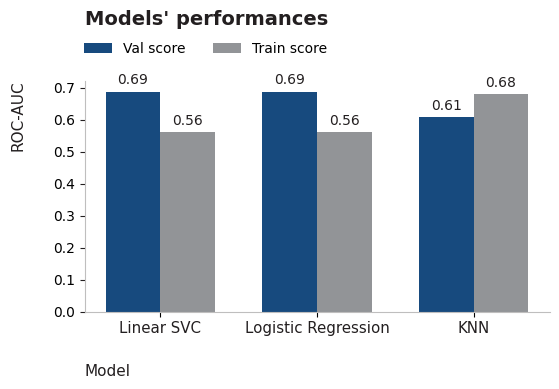

In [80]:
# K-fold cross validation for linear models.
eval_df = classification_kfold_cv(models=linear_models, 
                                  X_train=X_train_sample_linear, 
                                  y_train=y_train_sample, 
                                  n_folds=5)

plot_classification_kfold_cv(eval_df, bar_width=0.35, figsize=(6, 3), title_size=14, legend_x=0.26, legend_y=1.22, title_pad=40)

eval_df

Decision Tree results: 
--------------------------------------------------
Training score: 0.8468171422551901
Average validation score: 0.5590543942053572
Standard deviation: 0.005939364418700931
Training time: 0.33853 seconds

Random Forest results: 
--------------------------------------------------
Training score: 0.8587456153053515
Average validation score: 0.6215926766682001
Standard deviation: 0.005563400378559651
Training time: 6.4167 seconds

[LightGBM] [Info] Number of positive: 32303, number of negative: 67697
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 225
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.323030 -> initscore=-0.739882
[LightGBM] [Info] Start training from sco

,model,avg_val_score,train_score
0,LightGBM,0.690554,0.583564
1,Random Forest,0.621593,0.858746
2,Decision Tree,0.559054,0.846817


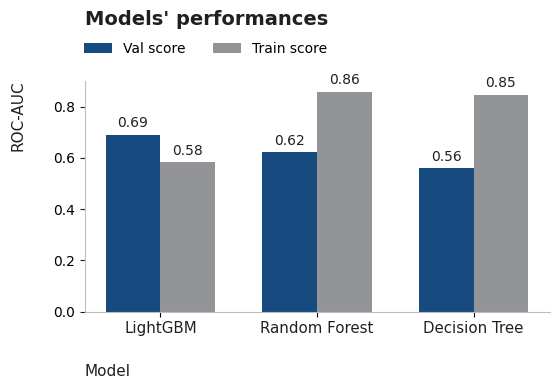

In [81]:
# K-fold cross validation for tree-based models.
eval_df = classification_kfold_cv(models=tree_models, 
                                  X_train=X_train_sample_tree, 
                                  y_train=y_train_sample, 
                                  n_folds=5)
plot_classification_kfold_cv(eval_df, bar_width=0.35, figsize=(6, 3), title_size=14, legend_x=0.26, legend_y=1.22, title_pad=40)
eval_df

- Machine learning é sim uma solução adequada para o problema, o nosso baseline Dummy Classifier foi batido.
- Dado que o melhor modelo foi o LightGBM e que estamos focando em poder preditivo, irei prosseguir com ele para a seleção de features e tunagem de hiperparâmetros. Apesar de o ajuste não ter sido tão bom (analisando o score de treino), o score de validação ainda é o maior.

#### 6. Seleção de features
- A etapa de feature selection é crucial para melhorar a habilidade de generalização do modelo e torná-lo menos complexo, diminuindo o custo computacional. Dado que temos milhões de linhas em nossos dados, simplificar o modelo sem perder performance é de grande proveito.
- O método escolhido será o ProbeFeatureSelection. Basicamente, é introduzida uma variável aleatória nos dados, seguindo uma distribuição especificada (normal, binominal, uniforme, etc.). Então, é acessada a feature importance de todas variáveis. Aquelas que possuem feature importance menor que a da Probe Feature serão removidas. 
- Escolhi esse método por conta da sua simplicidade, não aplicando testes estatísticos ou realizando suposições sobre os dados, além de seu custo reduzido, dada a simples remoção por corte de threshold (feature importance da Probe Feature).

In [7]:
# Instantiate the probe feature selector.
probe_selector = ProbeFeatureSelection(
    estimator=LGBMClassifier(),
    variables=None,
    scoring='neg_root_mean_squared_error',
    n_probes=1,
    distribution='normal',
    cv=3,
    random_state=42,
    confirm_variables=False
)

# Fit it to the training data.
X_train_sel_tree = probe_selector.fit_transform(X_train_prepared_tree, y_train)
X_test_sel_tree = probe_selector.transform(X_test_prepared_tree)

# Assess some results.
print()
print(f'Variáveis removidas: {probe_selector.features_to_drop_}')
print()
print(f'Variáveis remanescentes: {probe_selector.get_feature_names_out()}')
print()
print(f'Feature importances: ')
print(probe_selector.feature_importances_.sort_values(ascending=False))
print()
print(f'Dimensões do conjunto de treinamento final: {X_train_sel_tree.shape}')
print()
print(f'Dimensões do conjunto de teste final: {X_test_sel_tree.shape}')

[LightGBM] [Info] Number of positive: 637519, number of negative: 1328732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 498
[LightGBM] [Info] Number of data points in the train set: 1966251, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.324231 -> initscore=-0.734396
[LightGBM] [Info] Start training from score -0.734396
[LightGBM] [Info] Number of positive: 637518, number of negative: 1328733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 498
[LightGBM] [Info] Number of data points in the train set: 1966251, number of used features: 19
[LightGBM]

- Surpreendentemente, 11 variáveis tiveram feature importance menor que a Probe Feature, e foram removidas.

#### 7. Tunagem de hiperparâmetros
- Irei tunar os hiperparâmetros do LightGBM utilizando a otimização bayesiana através da biblioteca optuna.
- A otimização bayesiana realiza buscas inteligentes no espaço de hiperparâmetros do modelo, balanceando o trade-off exploration-exploitation.
- O grid search é ineficiente pois realiza uma busca exaustiva, testando todas as combinações de parâmetros possíveis e não considerando efeitos da interação entre parâmetros. Isso seria ruim no nosso caso, pois o conjunto de dados de treinamento é extenso e parâmetros como o número de árvores e a taxa de aprendizado estão relacionados a outros.
- Em cada iteração, treinaremos o modelo com os parâmetros no conjunto de treinamento e avaliaremos no conjunto de validação, para evitar o overfit decorrente do ajuste excessivo de hiperparâmetros no conjunto de treinamento.
- É importante definir o hiperparâmetro scale_pos_weight/class_weight, a fim de lidar com o desbalanceamento. Esse hiperparâmetro permitirá que o modelo aprenda melhor os padrões da classe minoritária (ausente (1)) dando maior peso a essas instâncias. Tal peso fará com que o custo da log-loss ao classificá-las erroneamente seja maior, resultando em uma melhor aprendizagem nessa classe. 
- A tunagem de hiperparâmetros representa um refinamento. O que melhora consideravelmente a performance do modelo é a etapa de feature engineering.
- A referência adotada para escolha dos hiperparâmetros pode ser encontrada no link a seguir. Normalmente, um maior número de árvores e iterações seria definido. Entretanto, dado o volume de dados, esses parâmetros serão reduzidos.

- https://www.linkedin.com/posts/pedro-almeida-ds_voc%C3%AA-fica-perdido-sobre-quais-combina%C3%A7%C3%B5es-activity-7168232226965385216-bvtw?utm_source=share&utm_medium=member_desktop

In [8]:
# Preprocess the validation set, apply the same probe feature selection and reset y_val indexes.
X_val_prepared_tree = tree_preprocessor.transform(X_val)
X_val_sel_tree = probe_selector.transform(X_val_prepared_tree)
y_val = y_val.reset_index(drop=True)

In [88]:
def objective(trial):
    # Define the hyperparameter search space.
    params = {
        'objective': 'binary',
        'metric': 'roc_auc',
        'n_estimators': 1000,
        'verbosity': -1,
        'bagging_freq': 1,
        'class_weight': 'balanced', 
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 2**10),
        'subsample': trial.suggest_float('subsample', 0.05, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.05, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
    }

    # Train the LightGBM model with the sampled hyperparameters.
    model = LGBMClassifier(**params)
    model.fit(X_train_sel_tree, y_train)

    # Make predictions on the validation set.
    y_pred = model.predict(X_val_sel_tree)

    # Calculate the root mean squared error.
    roc_auc = roc_auc_score(y_val, y_pred)

    return roc_auc

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=30)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2024-03-20 10:05:57,963] A new study created in memory with name: no-name-f9d80490-1478-47e9-bd98-045f4f3eeaaf


[I 2024-03-20 10:06:38,712] Trial 0 finished with value: 0.6349283261550023 and parameters: {'learning_rate': 0.015057237768327458, 'num_leaves': 249, 'subsample': 0.32184732100539987, 'colsample_bytree': 0.10124544328918013, 'min_data_in_leaf': 68}. Best is trial 0 with value: 0.6349283261550023.
[I 2024-03-20 10:08:47,525] Trial 1 finished with value: 0.6373569827438872 and parameters: {'learning_rate': 0.03344302956243582, 'num_leaves': 355, 'subsample': 0.9385609781986571, 'colsample_bytree': 0.528427110117521, 'min_data_in_leaf': 73}. Best is trial 1 with value: 0.6373569827438872.
[I 2024-03-20 10:10:03,830] Trial 2 finished with value: 0.6271320639644907 and parameters: {'learning_rate': 0.0013747244528622812, 'num_leaves': 555, 'subsample': 0.8628971427187574, 'colsample_bytree': 0.2640563709169402, 'min_data_in_leaf': 93}. Best is trial 1 with value: 0.6373569827438872.
[I 2024-03-20 10:11:27,877] Trial 3 finished with value: 0.6272041001777137 and parameters: {'learning_rate'

Best Hyperparameters: {'learning_rate': 0.028095483425366566, 'num_leaves': 167, 'subsample': 0.802292150133624, 'colsample_bytree': 0.9025697978357053, 'min_data_in_leaf': 20}


#### 8. Avaliação do modelo final

- Avaliarei a performance do modelo final tunado no conjunto de testes, dados nunca vistos antes pelo modelo, simulando o ambiente de produção.
- Para avaliá-lo, serão analisadas algumas métricas, como o ROC-AUC, KS, Gini, PR-AUC, recall, precision e brier score.
- Para o nosso problema, em que temos uma classificação binária desbalanceada, as principais métricas são o PR-AUC e o ROC-AUC. Considerando que estamos focando em probabilidades, o brier score também é interessante.
- Após avaliar o modelo, eu irei interpretar os seus resultados.

In [9]:
# Obtain best model with best parameters found in bayesian optimization.
best_params = {
                'objective': 'binary',
                'metric': 'roc_auc',
                'n_estimators': 1000,
                'verbosity': -1,
                'bagging_freq': 1,
                'class_weight': 'balanced',
                'learning_rate': 0.028095483425366566, 
                'num_leaves': 167, 
                'subsample': 0.802292150133624, 
                'colsample_bytree': 0.9025697978357053, 
                'min_data_in_leaf': 20
            }

lgb_clf = LGBMClassifier(**best_params)

# Obtain training + validation predictor and target sets.
X_train_prepared = pd.concat([X_train_sel_tree, X_val_sel_tree])
y_train_ = pd.concat([y_train, y_val])

# Fit the model to the training data and predicting.
lgb_clf.fit(X_train_prepared, y_train_)
y_pred = lgb_clf.predict(X_test_sel_tree)

In [10]:
# Obtain the predicted probabilities of the candidate being absent.
absent_probas = lgb_clf.predict_proba(X_test_sel_tree)[:, 1]

              precision    recall  f1-score   support

           0       0.80      0.57      0.67    175862
           1       0.44      0.70      0.54     84377

    accuracy                           0.62    260239
   macro avg       0.62      0.64      0.61    260239
weighted avg       0.68      0.62      0.63    260239

Brier Score: 0.22
Gini: 0.38
KS: 0.28


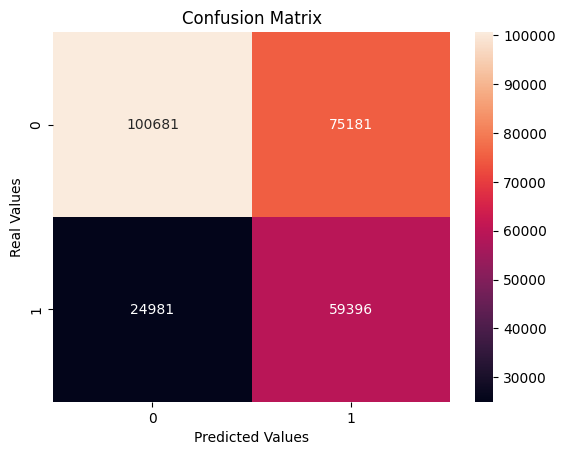

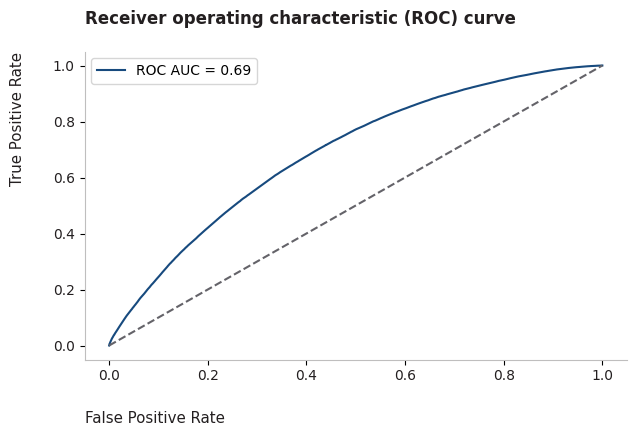

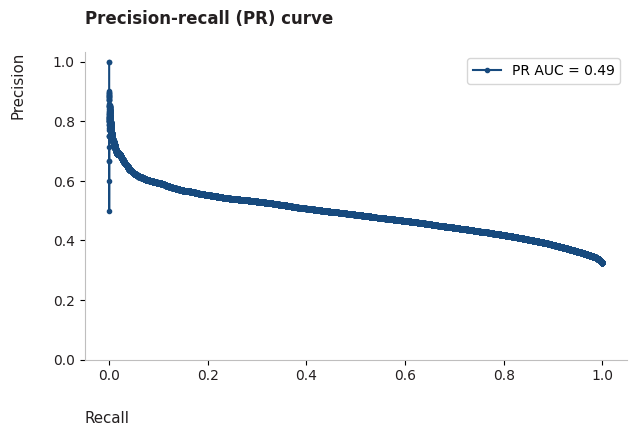

In [120]:
# Evaluate the classifier based on a bunch of metrics.
model_metrics = evaluate_classifier(y_test, y_pred, absent_probas)

In [121]:
model_metrics

,Metric,Value
0,Accuracy,0.615115
1,Precision,0.441353
2,Recall,0.703936
3,F1-Score,0.542543
4,ROC-AUC,0.688791
5,KS,0.276808
6,Gini,0.377582
7,PR-AUC,0.489326
8,Brier,0.223442



Os resultados do modelo são satisfatórios, porém há espaço para melhorias:
- Recall (0,7): O modelo identifica 70% dos ausentes. Na prática, observando a matriz de confusão, o modelo foi capaz de prever corretamente 59.396 dos 84.377 ausentes.
- Precision (0,44): De todos os candidatos preditos como ausentes, 44% se abstiveram de fato. Na prática, observando a matriz de confusão, dos 134.577 candidatos preditos como ausentes, 59.396 deles realmente se abstiveram.
- ROC AUC (0,69): Com um ROC AUC de 0,69, o modelo demonstra uma capacidade satisfatória de diferenciar entre ausentes e presentes. Se tomarmos ao acaso um candidato que se absteve e um candidato que estava presente, em 69% das vezes o modelo atribuirá probabilidade de abstenção maior àquele que estava ausente, que é o correto. Ademais, outras métricas como o KS e o Gini também indicam poder discriminatório satisfatório.
- PR AUC (0,49): Com um PR AUC de 0,49, o modelo demonstra espaço para melhorias, especialmente na precisão, que foi a métrica mais prejudicada.
- Brier score (0,22): O Brier score está próximo de zero e é satisfatório. Entretanto, também há espaço para melhorias. Como desejamos obter uma ordenação, não é necessário calibrar as probabilidades e focar em minimizar o brier score.

- Analisando as probabilidades, a fim de verificar como os scores estão distribuídos entre ausentes (1) e presentes (0).

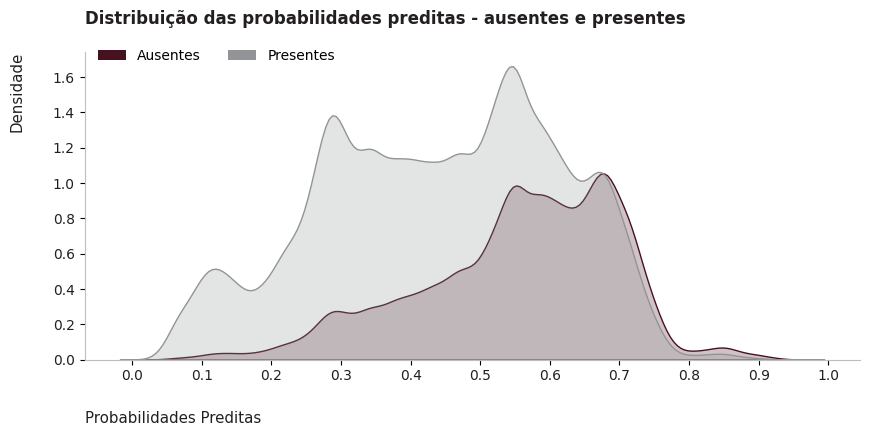

In [16]:
plot_probability_distributions(y_test, absent_probas)

- É possível perceber que não temos uma separação satisfatória entre as distribuições de probabilidade preditas para candidatos presentes e ausentes. Entretanto, para a maioria dos que se abstiveram, estamos prevendo probabilidades altas, o que é bom.
- Talvez seja interessante melhorar a precisão do modelo, que está baixa, e que provavelmente ocasiona essa sobreposição nas probabilidades, uma vez que estamos prevendo probabilidades altas mesmo para instâncias negativas.

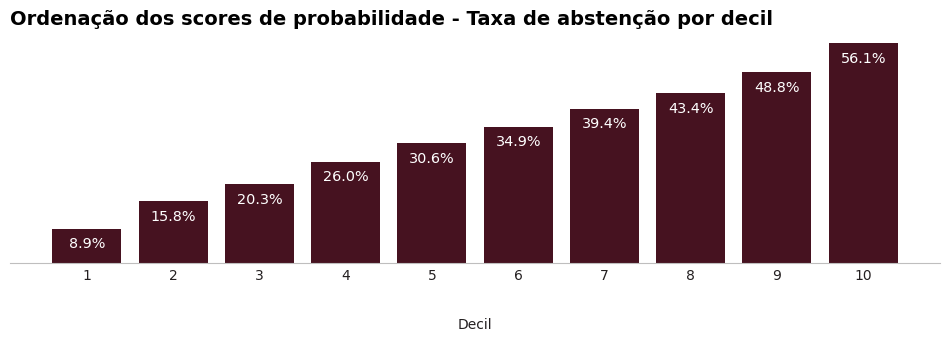

In [11]:
probability_scores_ordering(y_test, absent_probas)

- Nossos scores claramente seguem uma ordenação, o que é bom! É possível perceber que o percentual de candidatos ausentes é muito maior para faixas de probabilidade mais altas. Isso sugere que, apesar de não ser o melhor modelo possível, é sim muito útil para prever a probabilidade de abstenção de um estudante no enem e realizar uma ordenação.

- Finalmente, vamos comparar o ROC AUC do modelo nas amostras de treino, teste e validação, a fim de se certificar que o modelo não está com overfit. 
- Além disso, é importante aplicar a validação cruzada k-fold mais uma vez, a fim de verificar a performance do modelo em diferentes conjuntos de dados nunca antes vistos. Isso mitiga efeitos da variabilidade dos dados e nos fornece uma visão concreta da capacidade de generalização do estimador.

In [252]:
# Predict on train, test and validation sets.
y_pred_train = lgb_clf.predict_proba(X_train_prepared)[:, 1]
y_pred_val = lgb_clf.predict_proba(X_val_sel_tree)[:, 1]
y_pred_test = absent_probas

# K-fold cross validation
cv_scores = cross_val_score(lgb_clf,
                            X_train_prepared,
                            y_train_,
                            scoring='roc_auc',
                            cv=5)
roc_auc_cv = np.mean(cv_scores)

# Obtain ROC AUC on each of these sets.
roc_auc_train = round(roc_auc_score(y_train_, y_pred_train), 2)
roc_auc_test = round(roc_auc_score(y_test, y_pred_test), 2)
roc_auc_val = round(roc_auc_score(y_val, y_pred_val), 2)

# Output a dataframe for better visualization.
roc_auc_sets = pd.DataFrame({'ROC AUC': [roc_auc_train, roc_auc_test, roc_auc_val, roc_auc_cv]}, index=['Train', 'Test', 'Val', 'Cross Val'])
roc_auc_sets

,ROC AUC
Train,0.69000
Test,0.69000
Val,0.70000
Cross Val,0.68781


- Os scores nos conjuntos de treino, teste e validação e na validação cruzada k-fold são aproximadamente iguais. Portanto, o modelo não está com overfitting e generaliza de forma satisfatória para instâncias nunca antes vistas.

#### 9. Interpretação dos resultados
- Para interpretar os resultados do LightGBM, vou analisar os valores SHAP.
- SHAP é uma biblioteca que permite a interpretação dos resultados de algoritmos de machine learning.
- Com ela, podemos entender o impacto de cada característica em uma previsão individual do modelo.
- Basicamente, o valor SHAP de uma característica (o quanto ela impacta em uma previsão individual) é a soma ponderada das contribuições marginais considerando todas as possíveis combinações de características.
- Uma combinação de características é um grupo delas, e seu valor é a previsão individual do modelo utilizando apenas essas características.
- A contribuição marginal de uma característica é a diferença entre o valor previsto para uma combinação de características com ela e sem ela.
- Somamos as contribuições marginais para todas as possíveis combinações com e sem uma característica.
- Os pesos são baseados na probabilidade de a característica que estamos calculando o valor SHAP estar nessa combinação.
- Também podemos agregar as contribuições individuais, obtendo uma noção das feature importances. Vários plots serão explorados abaixo.

$$
\phi_i(v) = \sum_{S \subseteq F \setminus \{i\}} \frac{|S|!(|F| - |S| - 1)!}{|F|!} \left[ f(S \cup \{i\}) - f(S) \right]
$$

Onde:
- $ \phi_i(v) $ representa o SHAP value da feature $ i $ para a predição $ v $.
- $ F $ representa o conjunto de todas as features.
- $ S $ representa um subset de features excluindo a feature $ i $.
- $ f $ é a função de predição do modelo.

In [16]:
# Initialize the SHAP explainer with the final model.
explainer = shap.Explainer(lgb_clf)

# Compute shap values.
shap_values = explainer(X_test_sel_tree)

In [17]:
# Assess the shape.
np.shape(shap_values.values)

(260239, 7)

In [30]:
# Assess some true labels.
y_test.head(10)

0    1
1    0
2    0
3    1
4    0
5    0
6    0
7    0
8    1
9    0
Name: abstencao, dtype: int8

In [29]:
# Assess predicted probabilities of being absent.
absent_probas[0:10]

array([0.63888454, 0.7086585 , 0.604141  , 0.77356997, 0.54386474,
       0.67643572, 0.29781179, 0.2972295 , 0.53041992, 0.62789412])

- Temos 7 variáveis. Para cada uma temos um valor shap correspondente a cada observação.
- Para classificação binária, interpretamos os resultados em termos de log-odds. Nos gráficos a seguir, E(f(X)) representa a previsão média de log-odds. O log-odds é basicamente o logaritmo da odds, razão entre a probabilidade de o evento acontecer e a probabilidade de o evento não acontecer. O logaritmo é utilizado para converter a odds a uma escala linear. Os Valores de shap positivos aumentam o log-odds e, consequentemente, a probabilidade de abstenção, e vice-versa.
- Para obter a probabilidade de abstenção a partir do log-odds, basta passar a função logística, definida como $$ \text{sigmoid}(x) = \frac{1}{1 + e^{-\ln\left(\frac{p}{1-p}\right)}} $$

- Através do gráfico waterfall, iremos visualizar a contribuição de cada feature na predição para uma instância positiva (ausente) e negativa (presente).

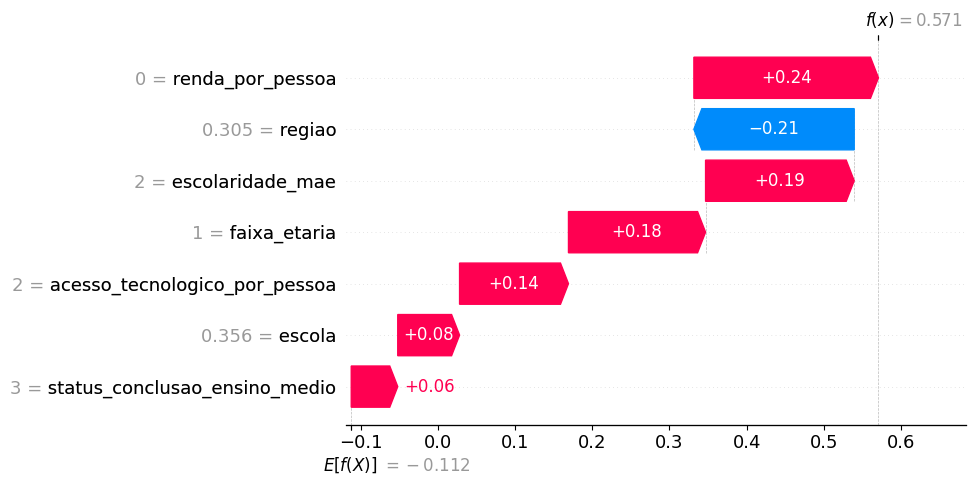

In [18]:
shap.plots.waterfall(shap_values[0])

- Este candidato estava ausente (1). A probabilidade de abstenção estimada para ele através da função logística mencionada acima é de aproximadamente 0.64.
- É possível perceber que a renda por pessoa (variável que criamos), que é igual a 0 neste caso, aumentou o log-odds em 0.24. Isso faz total sentido, uma vez que foi visto na eda que pessoas sem nenhuma renda tinham taxas de abstenção maiores que todas as outras faixas. O mesmo vale para a escolaridade da mãe, que, estando em um nível baixo (2, ensino fundamental incompleto), aumenta o log-odds em 0.19 e, consequentemente, a probabilidade de abstenção.
- De forma interessante, o fato de o candidato ser da região nordeste do país reduziu o log-odds em 0.21.

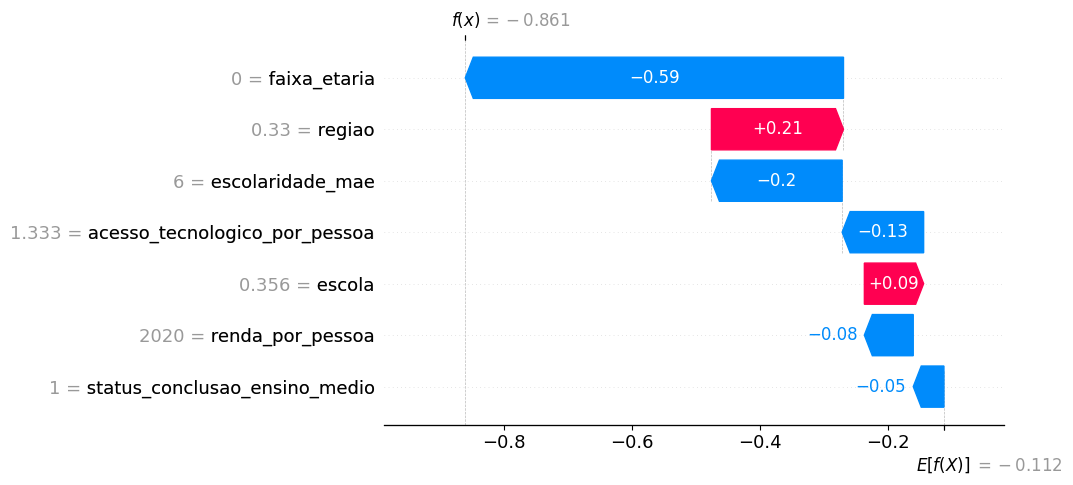

In [31]:
shap.plots.waterfall(shap_values[7])

- Este candidato estava presente (0). A probabilidade de abstenção estimada para ele através da função logística mencionada acima é de aproximadamente 0.30.
- A faixa etária, que corresponde ao grupo dos adolescentes, menores de idade, diminui o log-odds em 0.59 para esse candidato. Isso faz total sentido, uma vez que foi visto na eda que este grupo possui a menor taxa de asbtenção, e consequentemente, probabilidade de abstenção. O mesmo vale para a escolaridade da mãe, que é a maior possível, 6/pós-graduação, reduzindo o log-odds em 0.2.
- De forma interessante, o fato de o candidato ser da região sul aumenta o log-odds em 0.21.

- Agora, através do gráfico bar, iremos observer quais features são mais importantes. Neste gráfico, temos o shap absoluto médio para cada feature, indicando quais features contribuem mais (de forma positiva ou negativa) nas predições do modelo.

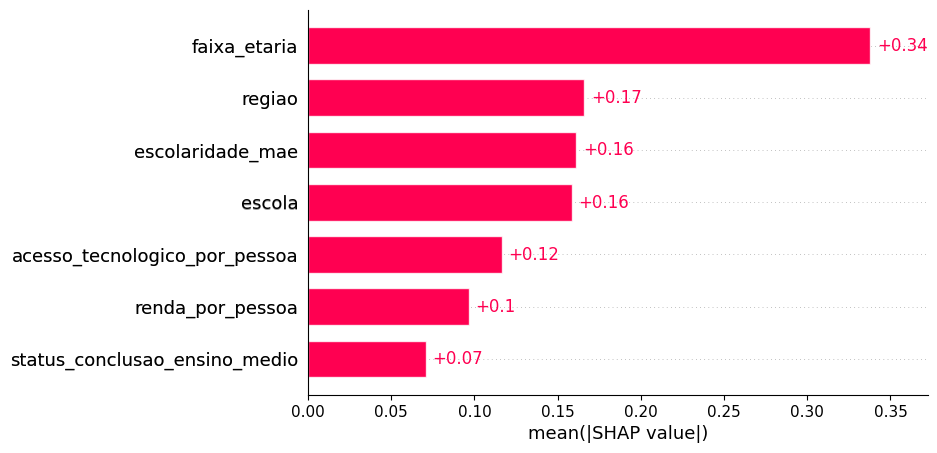

In [33]:
shap.plots.bar(shap_values)

- Como esperado, variáveis como a faixa etária, a escolaridade da mãe e o tipo de escola impactam de forma mais significativa os resultados do modelo. Com destaque para faixa etária, que é a mais importante de todas, com um shap absoluto médio de 0.34. 
- De forma interessante, a variável região aparece como sendo a segunda mais importante.

- Agora, através do gráfico beeswarm, podemos observar o relacionamento entre as features e a predição do modelo.

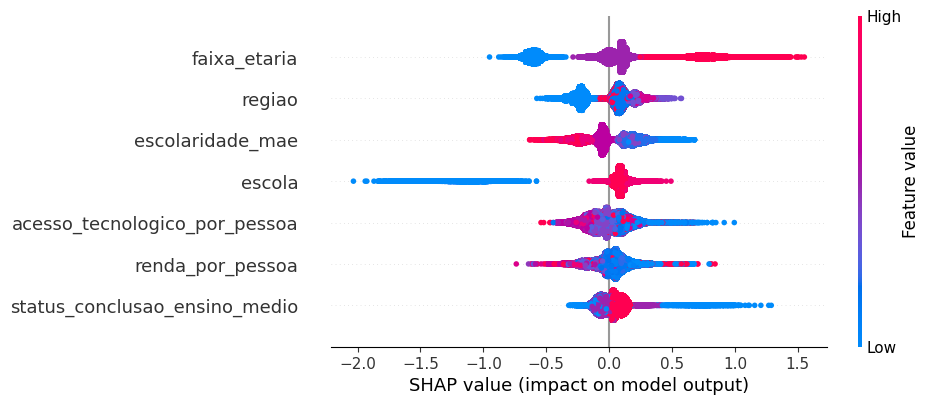

In [34]:
shap.plots.beeswarm(shap_values)

- Claramente, valores maiores de faixa etária, como idoso ou pré-aposentado, impactam de forma positiva (em maior magnitude) as predições do modelo. Isso significa um aumento na log-odds e, consequentemente, na probabilidade de abstenção. 
- Para o tipo de escola, temos uma clara separação. Valores menores, que correspondem a escola particular, impactam de forma negativa (em maior magnitude) as predições do modelo. Isso significa uma diminuição na log-odds e, consequentemente, na probabilidade de abstenção.
- Para renda e acesso tecnológico por pessoa, o contrário é verdadeiro, menores valores acarretam um aumento na log-odds e na probabilidade de abstenção.

#### 10. Conclusão

- Neste notebook, foi desenvolvido um modelo preditivo (LightGBM) para predição da probabilidade de abstenção do candidato no enem.
- Considerando que trata-se de uma classificação binária desbalanceada (temos aproximadamente 32% de ausentes contra 68% de presentes), algumas estratégias foram adotadas:
    - Divisão ESTRATIFICADA em treino, teste e validação, para manter a proporção das classes positiva e negativa do target em todas as amostras, permitindo uma avaliação confiável.
    - Validação cruzada k-fold ESTRATIFICADA pelo mesmo motivo.
    - Adoção do hiperparâmetro 'class_weight', aumentando o custo da log loss para erros de classificação de instâncias raras (positivas), resultando em um maior aprendizado dos padrões dessa classe.
    - Feature engineering na criação de features que ajudem o modelo a discriminar entre o evento (abstenção, 1) e o não evento.
    - Escolha de métricas orientadas a uma avaliação de performance condizente com o desbalanceamento, como PR-AUC, ROC-AUC, KS, Gini, recall, precision, f1-score e brier score.
- Foram consideradas diversas variáveis na construção do modelo. Os insights obtidos na etapa de análise exploratória de dados serviram de guia para a tarefa pré-processamento de dados, necessária para a aplicação de algoritmos de machine learning.
- Após o  pré-processamento de dados, avaliamos através da validação cruzada k-fold modelos potenciais, a fim de selecionar um deles para a seleção de features e tunagem de hiperparâmetros e avaliação final no conjunto de testes, simulando o ambiente de produção. O modelo selecionado foi o LightGBM por ter obtido o maior ROC-AUC de validação e o melhor ajuste no conjunto de treinamento.
- Realizei a feature selection introduzindo uma ProbeFeature, que é uma variável aleatória com distribuição normal. Então, aquelas variáveis com feature importance menor que o da Probe Feature foram removidas, restando 7 variáveis, simplificando o modelo e diminuindo o custo, dado que temos milhões de linhas.
- O resultado obtido foi satisfatório, porém há espaço para melhorias:
    - Obtivemos um ROC AUC de 0.69, indicando que o modelo possui um poder discriminante satisfatório entre as classes positiva e negativa. Isso nos indica que, se tomarmos ao acaso um candidato ausente e um presente, em 69% das vezes o modelo estimará uma probabilidade de abstenção mais alta para aquele que de fato se absteve.
    - Obtivemos um Recall 0.70, de modo que o modelo identifica corretamente 70% dos ausentes.
    - O modelo apresenta ordenação nos escores, com faixas de probabilidade mais altas contendo mais ausentes.
    - Os erros nas amostras de treino, teste e validação são similares, indicando que o modelo não está com overfit e generaliza de forma satisfatória para instâncias nunca antes vistas.
- Os resultados foram interpretados através da biblioteca SHAP, fornecendo uma visão do impacto de cada variável nas predições individuais e a sua importância agregada através dos SHAP values. Por exemplo, através do gráfico beeswarm, vemos que:
    - Claramente, valores maiores de faixa etária (variável mais importante), como idoso ou pré-aposentado, impactam de forma positiva (em maior magnitude) as predições do modelo. Isso significa um aumento na log-odds e, consequentemente, na probabilidade de abstenção. 
    - Para o tipo de escola, temos uma clara separação. Valores menores, que correspondem a escola particular, impactam de forma negativa as predições do modelo. Isso significa uma diminuição na log-odds e, consequentemente, na probabilidade de abstenção.
    - Para renda e acesso tecnológico por pessoa, o contrário é verdadeiro, menores valores acarretam um aumento na log-odds e na probabilidade de abstenção.
- Os próximos passos incluem o deploy do modelo.